In [105]:
import pyscheduling.JS.JmCmax as jm_cmax
import pyscheduling.JS.JmriwiTi as jm_wiTi
from pyscheduling.JS.JobShop import Job, JobShopSolution
from pyscheduling.Problem import Objective

from docplex.cp.model import CpoModel
from docplex.cp.solver.cpo_callback import CpoCallback
from docplex.cp.expression import INTERVAL_MAX

import networkx as nx
import matplotlib.pyplot as plt

%load_ext autoreload
%load_ext pycodestyle_magic
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [96]:
def visualize(results):
    """https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/04.03-Job-Shop-Scheduling.ipynb#scrollTo=RtQ5NWPTshoU"""
    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

visualize(results)

NameError: name 'results' is not defined

In [97]:
def csp_transform_solution(msol, M_k, types_k, instance ):

    sol = JobShopSolution(instance)
    for k in range(instance.m):
        k_tasks = []
        for i, oper_k_i in enumerate(M_k[k]):
            start, end, _ = msol[oper_k_i]
            k_tasks.append(Job(types_k[k][i],start,end))

            k_tasks = sorted(k_tasks, key= lambda x: x[1])
            sol.machines[k].job_schedule = k_tasks
    
    return sol

In [98]:
#instance = jm_cmax.JmCmax_Instance.generate_random(20,4)
#instance = jm_wiTi.JmriwiTi_Instance.generate_random(20,4)
instance = jm_wiTi.JmriwiTi_Instance.read_txt("deleteMe.txt")
E = range(instance.n)
M = range(instance.m)

model = CpoModel("JS_Model")

E_i = [[] for i in E]
M_k = [[] for k in M]

types_k = [ [] for k in M ]
for i in E:
    for oper in instance.P[i]:
        k, p_ik = oper
        start_period = (instance.R[i], INTERVAL_MAX) if hasattr(instance, 'R') else (0, INTERVAL_MAX)
        oper_i_k = model.interval_var( start = start_period,
                                       size = p_ik, optional= False, name=f'E[{i},{k}]')
        E_i[i].append(oper_i_k)
        
        M_k[k].append(oper_i_k)
        types_k[k].append(i)

# No overlap inside machines
seq_array = []
for k in M:
    seq_k = model.sequence_var(M_k[k], types_k[k], name=f"Seq_{k}")
    model.add( model.no_overlap(seq_k) )        
    seq_array.append(seq_k)

# Precedence constraint between machines for each job
for i in E:
    for k in range(1, len(E_i[i])):
        model.add( model.end_before_start(E_i[i][k - 1], E_i[i][k]) )

# Add objective
if instance.get_objective() == Objective.Cmax:
    model.add( model.minimize( model.max(model.end_of(job_i) for i in E for job_i in E_i[i]) ) )
if instance.get_objective() == Objective.wiTi:
    model.add( model.minimize( 
        sum( instance.W[i] * model.max(model.end_of(E_i[i][-1]) - instance.D[i], 0) for i in E ) 
            )) # sum_{i in E} wi*Ti

In [99]:
msol = model.solve(LogVerbosity="Normal", Workers=1, TimeLimit=30, LogPeriod=1000000,
                   log_output=True, trace_log=True, add_log_to_solution=True, RelativeOptimalityTolerance=0)

 ! --------------------------------------------------- CP Optimizer 20.1.0.0 --
 ! Minimization problem - 12 variables, 9 constraints
 ! TimeLimit            = 30
 ! Workers              = 1
 ! LogPeriod            = 1000000
 ! RelativeOptimalityTolerance = 0
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 28.5 (before), 28.5 (after)
 !  . Memory usage      : 441.2 kB (before), 441.2 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0         12                 -
 + New bound is 0
 *            18       19  0.00s               (gap is 100.0%)
              18       34         10        F         !presenceOf(E[1,2])
 + New bound is 18 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective 

In [100]:
sol = csp_transform_solution(msol, M_k, types_k, instance )

In [101]:
print(sol)

Objective : 0
Machine_ID | Job_schedule (job_id , start_time , completion_time) | Completion_time
1 | (1, 4, 9) : (0, 9, 14) : (2, 14, 21) | 0
2 | (2, 9, 12) : (1, 12, 18) : (0, 18, 28) | 0
3 | (1, 0, 4) : (2, 4, 9) : (0, 28, 32) | 0


In [102]:
sol.compute_objective()

18

In [104]:
sol.compute_objective_graph()

18

## Graph exploration

### Conjunctive graph - Instance

In [73]:
DG = create_instance_graph(instance)

In [74]:
#list(nx.topological_sort(DG))

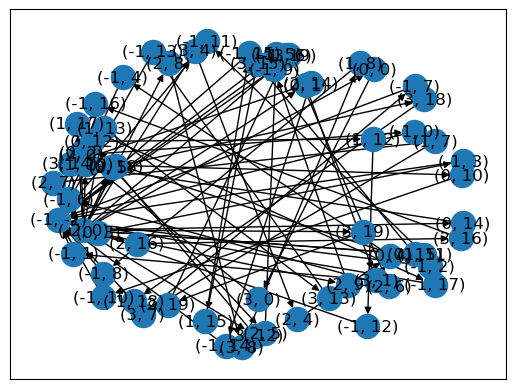

In [75]:
nx.draw_networkx(DG, arrows=True)

In [76]:
#nx.get_edge_attributes(DG, "weight")

In [77]:
nx.is_directed_acyclic_graph(DG)

True

In [78]:
DG.number_of_edges()

82

In [79]:
# Compute critical path
s = nx.single_source_bellman_ford(DG, source=(-2,0))

In [82]:
s[0][(-1, -1)]

-174

### Disjunctive graph - solution

In [67]:
DG_sol = create_solution_graph(sol)

In [68]:
DG_sol.number_of_edges()

120

In [69]:
nx.is_directed_acyclic_graph(DG)

True

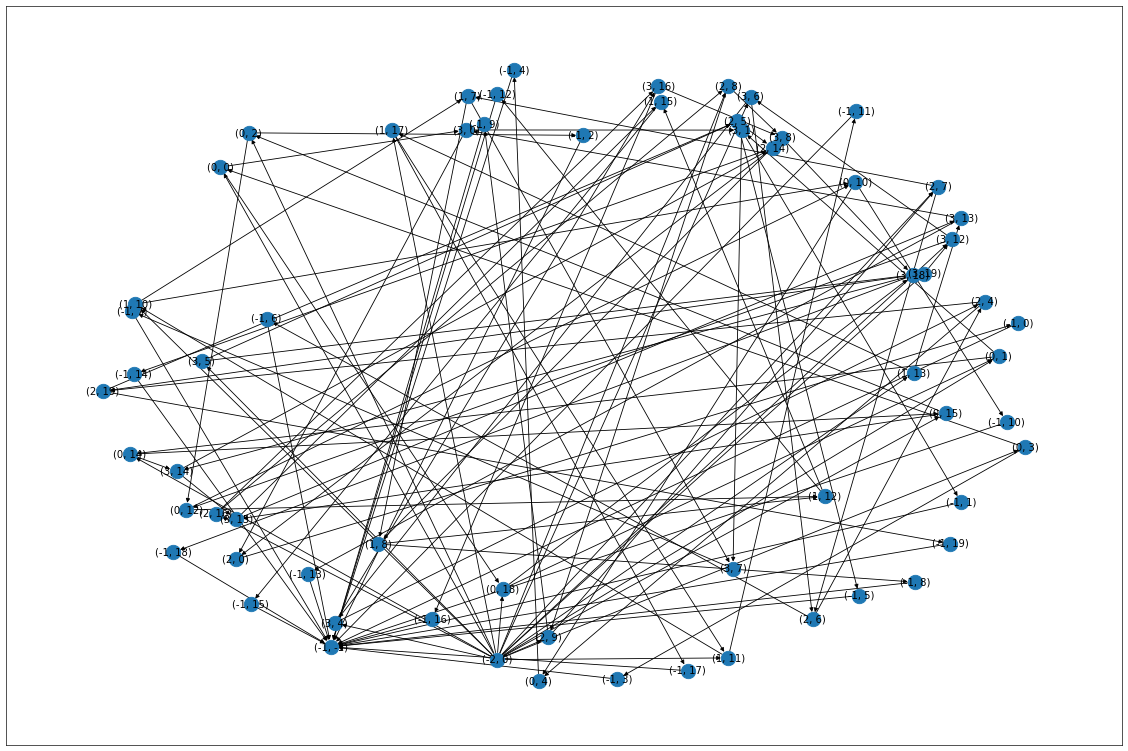

In [70]:
fig = plt.figure(1, figsize=(24, 16), dpi=60)
nx.draw_networkx(DG_sol, arrows=True)

In [83]:
# Compute critical path
s = nx.single_source_bellman_ford(DG_sol, source=(-2,0))

In [85]:
s[1][(-1,-1)]

[(-2, 0),
 (3, 5),
 (3, 19),
 (3, 12),
 (3, 6),
 (3, 4),
 (3, 16),
 (3, 8),
 (3, 18),
 (3, 14),
 (3, 15),
 (3, 13),
 (3, 0),
 (3, 1),
 (3, 7),
 (-1, 7),
 (-1, -1)]

In [86]:
sol.instance.P

[[(0, 64), (3, 66), (2, 44)],
 [(0, 61), (3, 66)],
 [(0, 60)],
 [(0, 36)],
 [(3, 32), (2, 53), (0, 56)],
 [(3, 41), (2, 61)],
 [(3, 66), (2, 32)],
 [(2, 42), (1, 33), (3, 36)],
 [(2, 37), (3, 40), (1, 31)],
 [(2, 64)],
 [(1, 65), (0, 61)],
 [(1, 58)],
 [(3, 36), (0, 38), (1, 35)],
 [(1, 55), (3, 66)],
 [(0, 48), (3, 34), (2, 57)],
 [(0, 48), (3, 49), (1, 52)],
 [(2, 35), (3, 56)],
 [(1, 40)],
 [(0, 47), (3, 32)],
 [(3, 35), (2, 37)]]

## Comparing with heuristics

In [21]:
solution = jm_wiTi.Heuristics.shifting_bottleneck(instance)
print(solution)

Search stopped with status : FEASIBLE
 Solution is : 
 Objective : 28
Machine_ID | Job_schedule (job_id , start_time , completion_time) | Completion_time
1 | (0, 5, 10) : (1, 10, 15) : (2, 15, 22) | 22
2 | (2, 5, 8) : (0, 10, 20) : (1, 20, 26) | 26
3 | (2, 0, 5) : (1, 5, 9) : (0, 20, 24) | 24 
Runtime is : 0.021562335998169146s 
time to best is : -1s 



In [22]:
machine = 0
list_events = sorted([(j_id, msol[M_k[machine][i]]) for i, j_id in enumerate(types_k[machine])], key = lambda x: x[1][0])
print("\n".join(map(str,list_events)))

(1, IntervalVarValue(start=4, end=9, size=5))
(0, IntervalVarValue(start=9, end=14, size=5))
(2, IntervalVarValue(start=14, end=21, size=7))
